# Spacial variational autoencoder for anomaly detection

In [1]:
from __future__ import absolute_import, division, print_function
import math
import numpy as np
import tensorflow as tf
import argparse
import os
import sys
import cv2
import glob
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from sklearn.model_selection import train_test_split
import scipy.misc
from scipy.misc import imsave
from vae import VAE
import time
from keras.preprocessing.image import ImageDataGenerator
from keras.utils. generic_utils import Progbar
from matplotlib import pyplot
from ops import *
flags = tf.flags
logging = tf.logging

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


## Dataset

In [2]:
def normalize_data(img):
    return (img.astype(np.float32) - 127.5) / 127.5

# load tomato images
def load_real_samples():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/training'
    
    trainAug = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.05,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest",
            preprocessing_function=normalize_data)
    
    trainGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=32)
    
    return trainGen

In [3]:
def get_coordinates(filename):
  filename_without_format = filename[:-4]
  filename_list = filename_without_format.split('_')
  coordinates_list = filename_list[-1].split('x')
  for item in range(len(coordinates_list)):
    coordinates_list[item] = int(coordinates_list[item])
  return coordinates_list

def load_test_data():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/testing/2019-09-19_06_47_32/'
    img_list = glob.glob(BASE_FOLDER + '*.png')
    images = list()
    coordinates = list()
    
    for img_path in img_list:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_NEAREST)
        img = (img.astype(np.float32) - 127.5) / 127.5
        images.append(img)
        position = get_coordinates(img_path)
        coordinates.append(position)
        
    print('Found ' + str(len(images)) + ' images for test.')
    return (np.asarray(images), coordinates)

In [4]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # get batch
    X, _ = dataset.next()
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [5]:
# select real samples
def generate_test_samples(X, n_samples):
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [6]:
# load image data
dataset = load_real_samples()
test_dataset, test_coordinates = load_test_data()

Found 191520 images belonging to 240 classes.
Found 798 images for test.


## Model

In [7]:
# Model parameters
batch_size = 32
max_epoch = 20
max_test_epoch = 2
learning_rate = 1e-4
working_directory = "/floyd/home/models/svae"
hidden_size = 2
channel = 96
checkpoint = 19
model_name = "low_rank"

In [8]:
model = VAE(hidden_size, batch_size, learning_rate, channel, model_name)

(32, 96, 2, 2)
(32, 96, 2, 2)
INFO:tensorflow:Summary name /KL-loss is illegal; using KL-loss instead.
INFO:tensorflow:Summary name /Rec-loss is illegal; using Rec-loss instead.
INFO:tensorflow:Summary name /loss is illegal; using loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step


## Train

In [9]:
# prepare lists for storing stats each iteration
loss_value_hist, kl_loss_hist, rec_loss_hist = list(), list(), list()

for epoch in range(max_epoch):
    print('epoch', epoch)
    n_iter = len(dataset)
    progress_bar = Progbar(target=n_iter)
    t_start= time.clock()
    for i in range(n_iter):
        images, _ = generate_real_samples(dataset, batch_size)
        loss_value, kl_loss, rec_loss = model.update_params(images, epoch*n_iter + i)
        progress_bar.update(i, values=[('loss_value', loss_value), ('kl_loss', kl_loss), ('rec_loss', rec_loss)])
        loss_value_hist.append(loss_value)
        kl_loss_hist.append(kl_loss)
        rec_loss_hist.append(rec_loss)
    t_end = time.clock()
    print('')
    print ("training per epoch time ====== %f" %(t_end-t_start))
    model.save(epoch)
    print('')
    model.generate_and_save_images(batch_size, working_directory)
    dataset.on_epoch_end()

epoch 0
5984/5985 [============================>.] - ETA: 0s - loss_value: 0.1953 - kl_loss: 0.0512 - rec_loss: 0.1441
training per epoch time ====== 330.001993
---->saving 0
INFO:tensorflow:./modeldir/model-0 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.023050
epoch 1
5984/5985 [============================>.] - ETA: 0s - loss_value: 0.1221 - kl_loss: 0.0232 - rec_loss: 0.0989
training per epoch time ====== 330.797458
---->saving 1
INFO:tensorflow:./modeldir/model-1 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003601
epoch 2
5984/5985 [============================>.] - ETA: 0s - loss_value: 0.1097 - kl_loss: 0.0231 - rec_loss: 0.0866
training per epoch time ====== 330.998419
---->saving 2
INFO:tensorflow:./modeldir/model-2 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003618
epoch 3
5984/5985 [============================>.] - ETA: 0s - loss_value: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5584/5985 [==========================>...] - ETA: 21s - loss_value: 0.0959 - kl_loss: 0.0258 - rec_loss: 0.0700

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5984/5985 [============================>.] - ETA: 0s - loss_value: 0.0955 - kl_loss: 0.0259 - rec_loss: 0.0696
training per epoch time ====== 329.441291
---->saving 13
INFO:tensorflow:./modeldir/model-13 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003847
epoch 14
 177/5985 [..............................] - ETA: 5:07 - loss_value: 0.0956 - kl_loss: 0.0260 - rec_loss: 0.0696

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5199/5985 [=========================>....] - ETA: 41s - loss_value: 0.0951 - kl_loss: 0.0259 - rec_loss: 0.0693

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5984/5985 [============================>.] - ETA: 0s - loss_value: 0.0948 - kl_loss: 0.0259 - rec_loss: 0.0689
training per epoch time ====== 331.246044
---->saving 15
INFO:tensorflow:./modeldir/model-15 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003111
epoch 16
5984/5985 [============================>.] - ETA: 0s - loss_value: 0.0945 - kl_loss: 0.0259 - rec_loss: 0.0686
training per epoch time ====== 332.353556
---->saving 16
INFO:tensorflow:./modeldir/model-16 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003353
epoch 17
5984/5985 [============================>.] - ETA: 0s - loss_value: 0.0943 - kl_loss: 0.0259 - rec_loss: 0.0684
training per epoch time ====== 331.544512
---->saving 17
INFO:tensorflow:./modeldir/model-17 is not in all_model_checkpoint_paths. Manually adding it.

image generation time is ==== 0.003795
epoch 18
5984/5985 [============================>.] - ETA: 0s - loss_value: 

## Evaluation

In [9]:
### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

INFO:tensorflow:Restoring parameters from ./modeldir/model-19
model load successfully===================
(3200, 48, 48, 3)


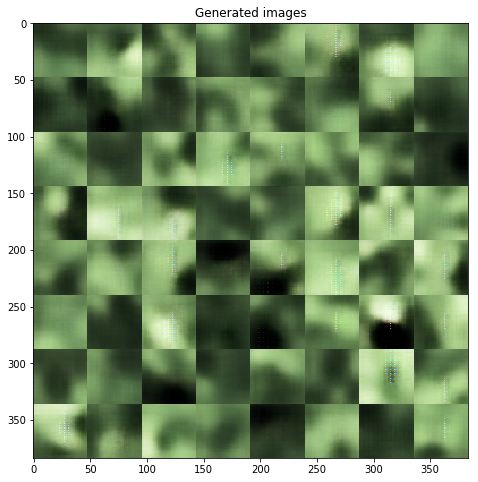

In [10]:
model.reload(checkpoint)
samples = model.generate_samples()
ix = randint(0, samples.shape[0], 64)
# select images
X = samples[ix]

img = combine_images(X)
img = (img*127.5)+127.5
img = img.astype(np.uint8)

### plt view
pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Generated images')
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.show()

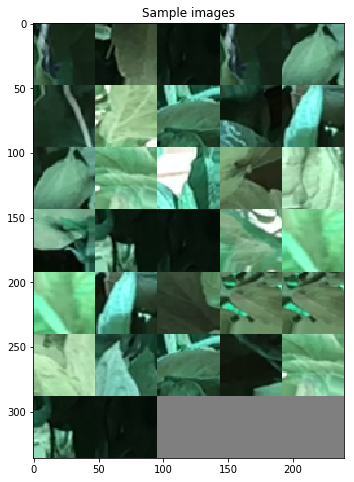

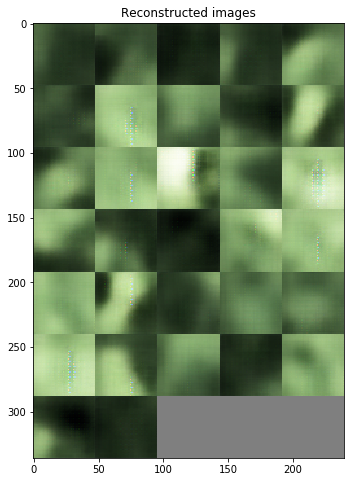

In [19]:
test_samples, _ = generate_real_samples(dataset, 32)
res = model.sess.run(model.output_tensor,{model.input_tensor: test_samples})

img = combine_images(test_samples)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = combine_images(res)
img2 = (img2*127.5)+127.5
img2 = img2.astype(np.uint8)

### plt view
pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Sample images')
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.show()

pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Reconstructed images')
pyplot.imshow(img2, cmap=pyplot.cm.gray)
pyplot.show()

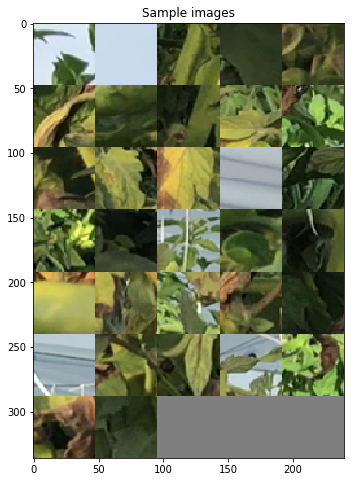

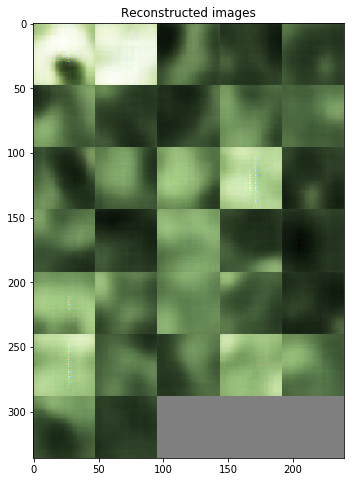

In [18]:
test_samples, _ = generate_test_samples(test_dataset, 32)
res = model.sess.run(model.output_tensor,{model.input_tensor: test_samples})

img = combine_images(test_samples)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = combine_images(res)
img2 = (img2*127.5)+127.5
img2 = img2.astype(np.uint8)

### plt view
pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Sample images')
pyplot.imshow(img, cmap=pyplot.cm.gray)
pyplot.show()

pyplot.figure(num=0, figsize=(8, 8))
pyplot.title('Reconstructed images')
pyplot.imshow(img2, cmap=pyplot.cm.gray)
pyplot.show()